In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt

# Sales Analysis and Forecasting for Istanbul 

In this notebook, we will analyze the quarterly and monthly sales data of the choosen SKU's for Istanbul. We will use the Exponential Smoothing, Moving Average, Naive, Triple Exponential Smoothing, ARIMA, and SARIMA forecasting methods to forecast the sales of the choosen SKU's for the next 4 quarters and 12 months.

### Choosen SKU's
- I. Segment: 568 (challenge olan), 578, 1050
- II. Segment: 319 (en stabil olan), 509/615, 1018 (düşük satışlı olan)

```python
data = pd.read_csv('data/istanbul_data_preprocessed.csv')

name_cols = ['MainDistID', 'DistID', 'HcoID', 'SkuID']
categorical_cols = ['HcoType', 'SalesRegionID'] # 'SalesRegionID_x','SalesRegionID_y', 
numerical_cols = ['PaidQty', 'FGQty', 'TotalQuantity', 'Week', 'Quarter', 'Month', 'Year']
boolean_cols = ['IsReturn', 'IsMrsOrder', 'Status']

data['Date'] = pd.to_datetime(data['Date'])
data['Week'] = data['Date'].dt.isocalendar().week
data['Month'] = data['Date'].dt.month
data['Quarter'] = data['Date'].dt.quarter
data['Year'] = data['Date'].dt.year

# if sales region x and y are the same save 
data = data[data['SalesRegionID_x'] == data['SalesRegionID_y']]

# merge region cols 
data['SalesRegionID'] = data['SalesRegionID_x'].combine_first(data['SalesRegionID_y'])
data.drop(columns=['SalesRegionID_x', 'SalesRegionID_y'], inplace=True)

data['Status'] = data['Status'].apply(lambda x: True if x == 'Active' else False)
```

# Importing the Data

In [4]:
data = pd.read_csv('data/istanbul_data_fully_preprocessed.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863002 entries, 0 to 863001
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   MainDistID     863002 non-null  int64 
 1   DistID         863002 non-null  int64 
 2   Date           863002 non-null  object
 3   HcoID          863002 non-null  int64 
 4   BrandID        863002 non-null  int64 
 5   SkuID          863002 non-null  int64 
 6   IsReturn       863002 non-null  bool  
 7   PaidQty        863002 non-null  int64 
 8   FGQty          863002 non-null  int64 
 9   IsMrsOrder     863002 non-null  bool  
 10  HcoType        863002 non-null  object
 11  District       857497 non-null  object
 12  Status         863002 non-null  bool  
 13  TotalQuantity  863002 non-null  int64 
 14  Week           863002 non-null  int64 
 15  Month          863002 non-null  int64 
 16  Quarter        863002 non-null  int64 
 17  Year           863002 non-null  int64 
 18  Sale

In [15]:
name_cols = ['MainDistID', 'DistID', 'HcoID', 'SkuID', 'BrandID', 'District']
categorical_cols = ['HcoType', 'SalesRegionID'] 
numerical_cols = ['PaidQty', 'FGQty', 'TotalQuantity', 'Week', 'Quarter', 'Month', 'Year']
boolean_cols = ['IsReturn', 'IsMrsOrder', 'Status']


# convert categorical columns to 'category' data type
for col in categorical_cols:
    data[col] = data[col].astype('category')

# convert numerical columns to 'int' data type
for col in numerical_cols:
    data[col] = data[col].astype('int')
    
# convert name columns to str data type
for col in name_cols:
    data[col] = data[col].astype(str)

# convert boolean columns to 'bool' data type
for col in boolean_cols:
    data[col] = data[col].astype(bool)
    
raw_data = data.copy()

In [16]:
data.head()

,MainDistID,DistID,Date,HcoID,BrandID,SkuID,IsReturn,PaidQty,FGQty,IsMrsOrder,HcoType,District,Status,TotalQuantity,Week,Month,Quarter,Year,SalesRegionID
276,2879266,2878724,2019-01-03,2862447,15,319,False,1,0,False,P,KÜÇÜKÇEKMECE,True,1,1,1,1,2019,341903
277,2879266,2878724,2019-01-07,2862447,15,319,False,1,0,False,P,KÜÇÜKÇEKMECE,True,1,2,1,1,2019,341903
278,2879266,2878724,2019-01-07,2862447,15,319,False,1,0,False,P,KÜÇÜKÇEKMECE,True,1,2,1,1,2019,341903
279,2879266,2878724,2019-01-08,2862447,15,319,False,1,0,False,P,KÜÇÜKÇEKMECE,True,1,2,1,1,2019,341903
280,2879266,2878724,2019-01-14,2862447,15,319,False,4,0,False,P,KÜÇÜKÇEKMECE,True,4,3,1,1,2019,341903


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182796 entries, 276 to 862762
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   MainDistID     182796 non-null  object  
 1   DistID         182796 non-null  object  
 2   Date           182796 non-null  object  
 3   HcoID          182796 non-null  object  
 4   BrandID        182796 non-null  object  
 5   SkuID          182796 non-null  object  
 6   IsReturn       182796 non-null  bool    
 7   PaidQty        182796 non-null  int64   
 8   FGQty          182796 non-null  int64   
 9   IsMrsOrder     182796 non-null  bool    
 10  HcoType        182796 non-null  category
 11  District       182796 non-null  object  
 12  Status         182796 non-null  bool    
 13  TotalQuantity  182796 non-null  int64   
 14  Week           182796 non-null  int64   
 15  Month          182796 non-null  int64   
 16  Quarter        182796 non-null  int64   
 17  Year         

# Selecting Features (Columns)

- **SkuID**: SKU ID
- **MainDistID**: Main Distribution ID
- **District**: District Name
- **SalesRegionID**: Sales Region ID
- **Date**: Date of Sales
- **Year**: Year of Sales
- **Quarter**: Quarter of Sales
- **Month**: Month of Sales
- **Week**: Week of Sales
- **TotalQuantity**: Total Quantity Sold

In [18]:
print(data.columns)
df_cleaned = data.copy()

# 'DistID', 'Date', 'HcoID', 'BrandID', 'SkuID', 'IsReturn', 'PaidQty', 'FGQty', 'IsMrsOrder', 'HcoType', 'Status',
df_cleaned = df_cleaned[['SkuID', 'MainDistID', 'District', 'SalesRegionID', 'Date', 'Year', 'Quarter', 'Month', 'Week', 'TotalQuantity']]

df_cleaned.info()

Index(['MainDistID', 'DistID', 'Date', 'HcoID', 'BrandID', 'SkuID', 'IsReturn',
       'PaidQty', 'FGQty', 'IsMrsOrder', 'HcoType', 'District', 'Status',
       'TotalQuantity', 'Week', 'Month', 'Quarter', 'Year', 'SalesRegionID'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 182796 entries, 276 to 862762
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   SkuID          182796 non-null  object  
 1   MainDistID     182796 non-null  object  
 2   District       182796 non-null  object  
 3   SalesRegionID  182796 non-null  category
 4   Date           182796 non-null  object  
 5   Year           182796 non-null  int64   
 6   Quarter        182796 non-null  int64   
 7   Month          182796 non-null  int64   
 8   Week           182796 non-null  int64   
 9   TotalQuantity  182796 non-null  int64   
dtypes: category(1), int64(5), object(4)
memory usage: 14.1+ MB


# SKU and District Selection

In [22]:
segment_1_sku_ids = ["568", "578", "1050"]
segment_2_sku_ids = ["319", "509", "615", "1018"]

all_sku_ids = segment_1_sku_ids + segment_2_sku_ids

data = data[data['SkuID'].isin(all_sku_ids)]

In [23]:
highest_districts = ['PENDİK','GAZİOSMANPAŞA','KÜÇÜKÇEKMECE','ÜMRANİYE','FATİH']
data = data[data['District'].isin(highest_districts)]

In [24]:
data['District'].unique()

array(['KÜÇÜKÇEKMECE', 'GAZİOSMANPAŞA', 'FATİH', 'ÜMRANİYE', 'PENDİK'],
      dtype=object)

In [25]:
# convert District column to 'category' data type
data['District'] = data['District'].astype('category')

In [26]:
data.describe(include=['category', 'object'])

,MainDistID,DistID,Date,HcoID,BrandID,SkuID,HcoType,District,SalesRegionID
count,182796,182796,182796,182796,182796,182796,182796,182796,182796
unique,14,36,1096,1150,7,7,1,5,31
top,2879266,2878817,2020-12-18,2856200,29,568,P,KÜÇÜKÇEKMECE,342101
freq,71121,52836,585,720,50717,50717,182796,42786,21895


In [27]:
# Grouping by Sales Region and calculating aggregate metrics
district_agg = data.groupby('District').agg({
    'TotalQuantity': ['sum', 'mean', 'std']
}).reset_index()

district_agg.columns = ['District', 'TotalQuantity_sum', 'TotalQuantity_mean', 'TotalQuantity_std']

print(district_agg)

        District  TotalQuantity_sum  TotalQuantity_mean  TotalQuantity_std
0          FATİH             207681            5.559657          10.305968
1  GAZİOSMANPAŞA             255257            7.339189          20.662225
2   KÜÇÜKÇEKMECE             261429            6.110153          15.601229
3         PENDİK             250376            7.518347          16.859351
4       ÜMRANİYE             222097            6.424001          14.444544


# Encoding Categorical Variables

In [28]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Label Encoding for binary categorical variables
label_encoder = LabelEncoder()

# One-Hot Encoding for other categorical variables
df_encoded = pd.get_dummies(df_cleaned, columns=['MainDistID', 'District'])

print('Data after encoding:')
df_encoded.head()

Data after encoding:


,SkuID,SalesRegionID,Date,Year,Quarter,Month,Week,TotalQuantity,MainDistID_2879231,MainDistID_2879236,...,MainDistID_2879276,MainDistID_2886479,MainDistID_2908099,MainDistID_2915715,MainDistID_2918750,District_FATİH,District_GAZİOSMANPAŞA,District_KÜÇÜKÇEKMECE,District_PENDİK,District_ÜMRANİYE
276,319,341903,2019-01-03,2019,1,1,1,1,False,False,...,False,False,False,False,False,False,False,True,False,False
277,319,341903,2019-01-07,2019,1,1,2,1,False,False,...,False,False,False,False,False,False,False,True,False,False
278,319,341903,2019-01-07,2019,1,1,2,1,False,False,...,False,False,False,False,False,False,False,True,False,False
279,319,341903,2019-01-08,2019,1,1,2,1,False,False,...,False,False,False,False,False,False,False,True,False,False
280,319,341903,2019-01-14,2019,1,1,3,4,False,False,...,False,False,False,False,False,False,False,True,False,False


# Data for Monthly Analysis

In [29]:
monthly_data = df_cleaned.copy()
monthly_data = monthly_data.groupby(['Year', 'Month', 'SkuID']).agg({'TotalQuantity': 'sum'}).reset_index()
monthly_data

,Year,Month,SkuID,TotalQuantity
0,2019,1,1018,923
1,2019,1,1050,4372
2,2019,1,319,3401
3,2019,1,509,2862
4,2019,1,568,11691
...,...,...,...,...
247,2021,12,319,6030
248,2021,12,509,2565
249,2021,12,568,11213
250,2021,12,578,6255


## Plots

### Total Quantity by SKU Function

In [30]:
def plot_total_quantity(sku_id, data, title='Total Quantity by Quarter', xlabel='Quarter', ylabel='Total Quantity'):
    sku = data[data['SkuID'] == sku_id]
    plt.figure(figsize=(12, 6))
    
    # define if the x is week, month or quarter
    if xlabel == 'Quarter':
        x = sku['Year'].astype(str) + '-' + sku['Quarter'].astype(str)
    elif xlabel == 'Month':
        x = sku['Year'].astype(str) + '-' + sku['Month'].astype(str)
    else:
        x = sku['Year'].astype(str) + '-' + sku['Week'].astype(str)
        
    plt.plot(x, sku['TotalQuantity'])
    
    plt.title(f'SKU {sku_id} - {title}')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.show()

### Implementing Moving Average for each SKU to see the trend and seasonality

SKU 568


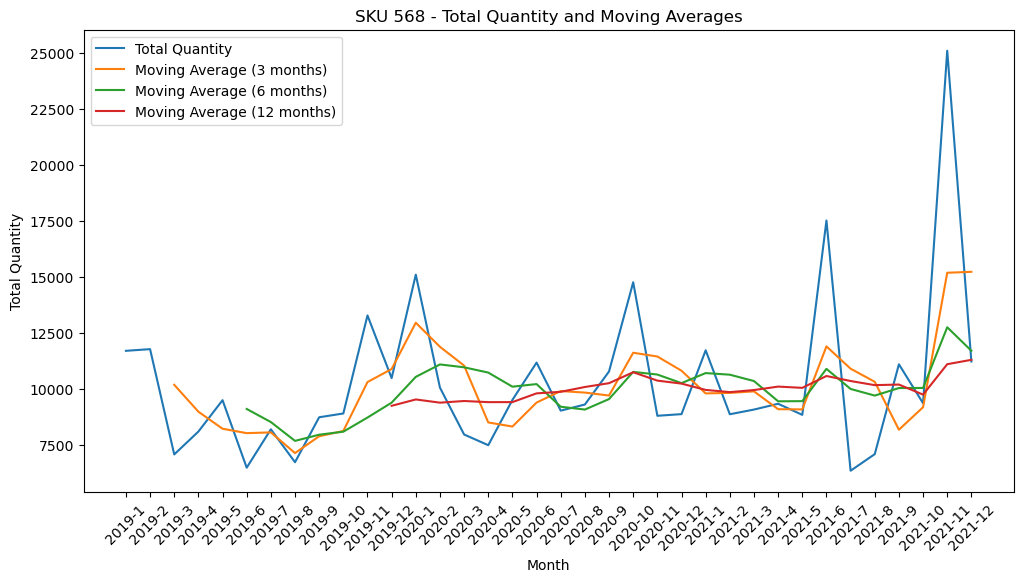

SKU 578


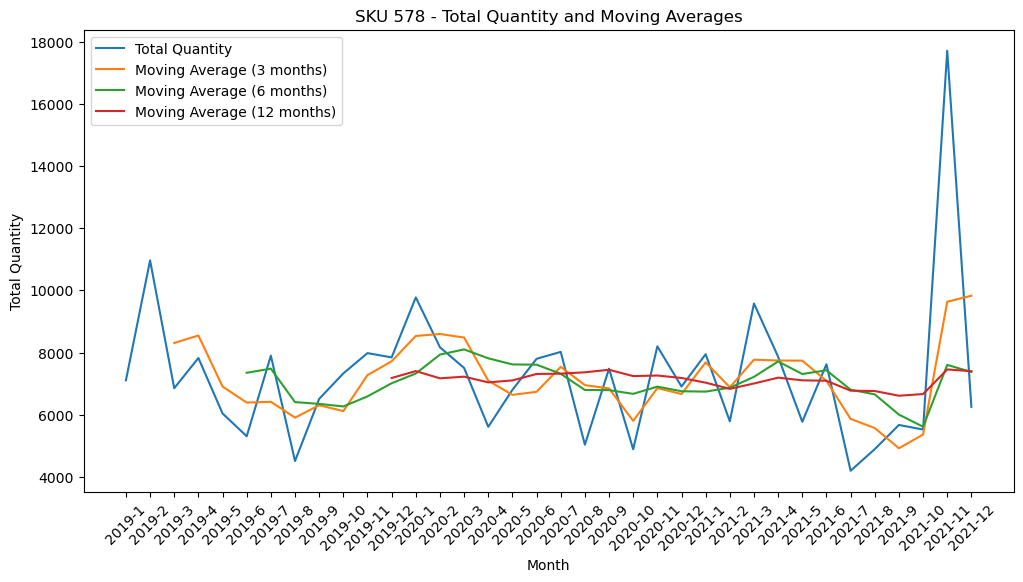

SKU 1050


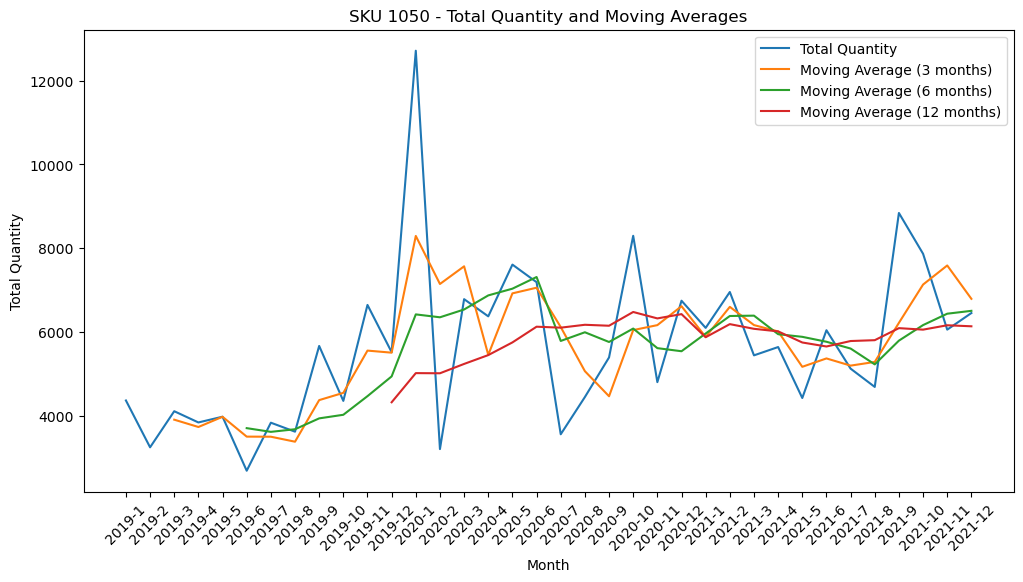

SKU 319


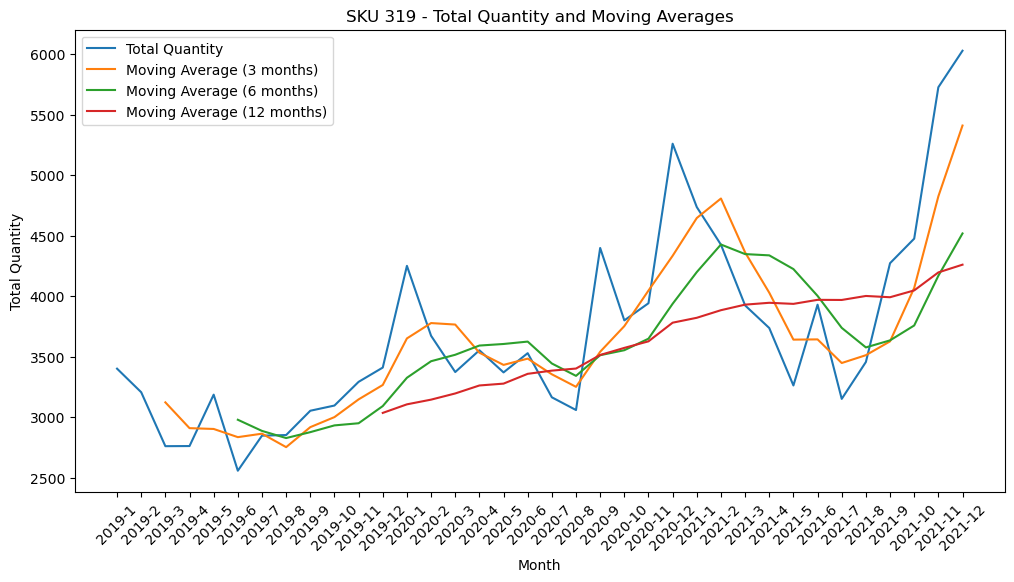

SKU 509


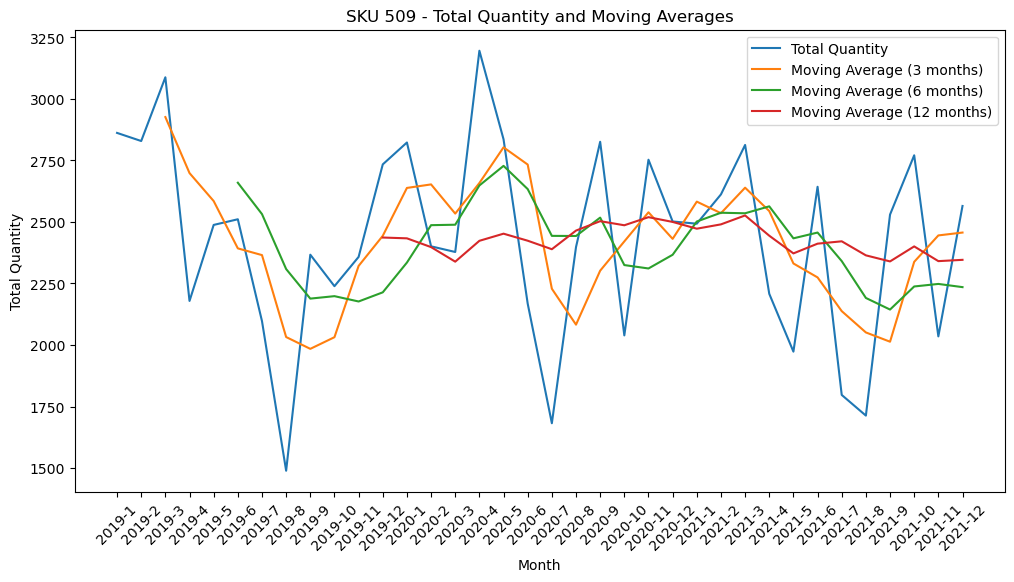

SKU 615


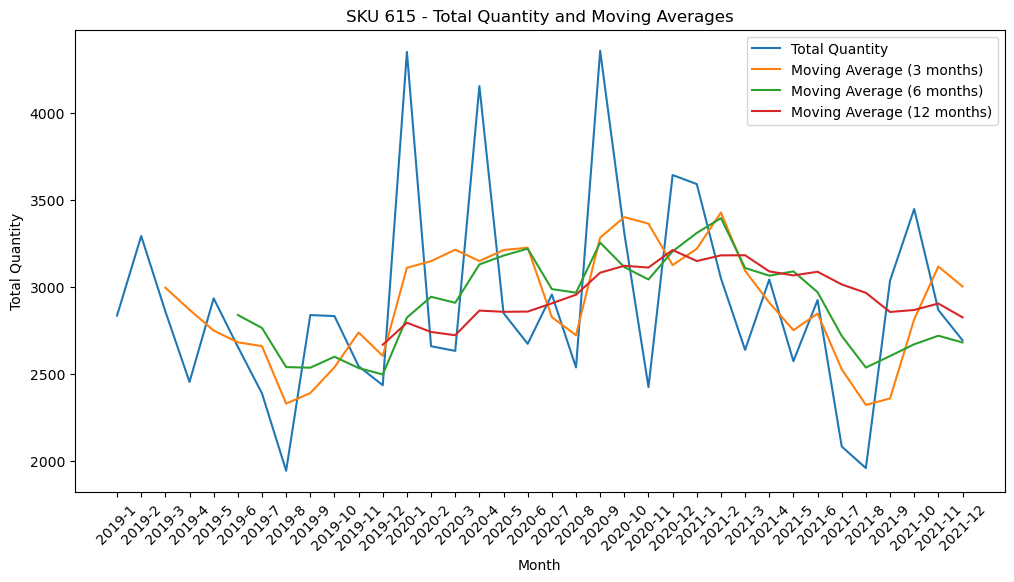

SKU 1018


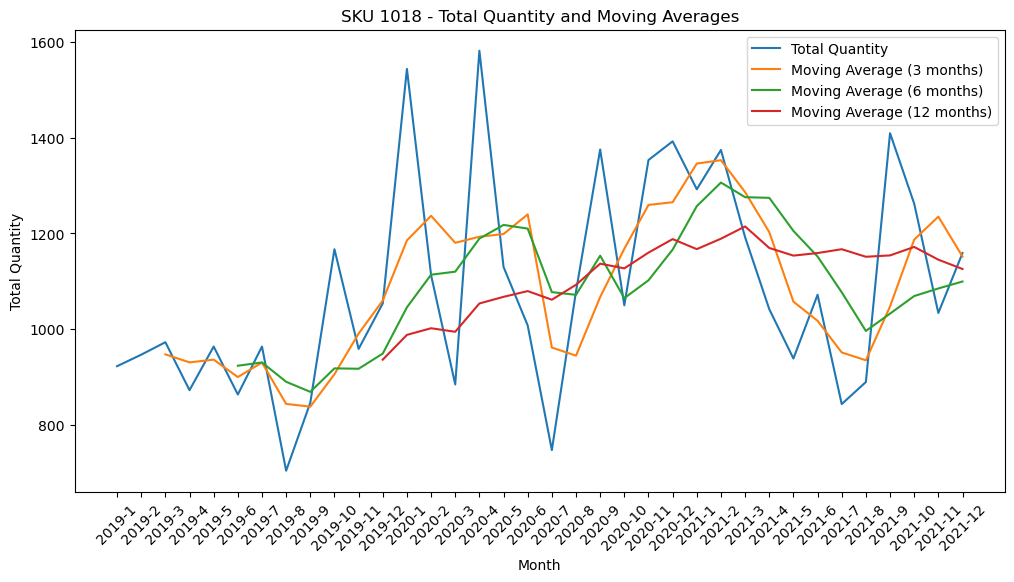

In [31]:
for sku_id in all_sku_ids:
    print(f'SKU {sku_id}')
    sku_data = monthly_data[monthly_data['SkuID'] == sku_id]
    x = sku_data['Year'].astype(str) + '-' + sku_data['Month'].astype(str)
    
    # Calculate the moving average
    sku_data['Moving_Average_3'] = sku_data['TotalQuantity'].rolling(window=3).mean()
    sku_data['Moving_Average_6'] = sku_data['TotalQuantity'].rolling(window=6).mean()
    sku_data['Moving_Average_12'] = sku_data['TotalQuantity'].rolling(window=12).mean()
    
    plt.figure(figsize=(12, 6))
    plt.plot(x, sku_data['TotalQuantity'], label='Total Quantity')
    plt.plot(x, sku_data['Moving_Average_3'], label='Moving Average (3 months)')
    plt.plot(x, sku_data['Moving_Average_6'], label='Moving Average (6 months)')
    plt.plot(x, sku_data['Moving_Average_12'], label='Moving Average (12 months)')
    
    plt.title(f'SKU {sku_id} - Total Quantity and Moving Averages')
    plt.xlabel('Month')
    plt.ylabel('Total Quantity')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()


# Quarterly Sales Analysis

Calculate the total sales of the choosen SKU's for quarterly. It should be 12 rows in total for every SKU.

In [32]:
quarterly_data = df_cleaned.copy()

quarterly_data = quarterly_data.groupby(['Year', 'Quarter', 'SkuID']).agg({'TotalQuantity': 'sum'}).reset_index()
quarterly_data

,Year,Quarter,SkuID,TotalQuantity
0,2019,1,1018,2843
1,2019,1,1050,11743
2,2019,1,319,9367
3,2019,1,509,8779
4,2019,1,568,30520
...,...,...,...,...
79,2021,4,319,16234
80,2021,4,509,7371
81,2021,4,568,45659
82,2021,4,578,29486


## Total Quantity Plot for each SKU

SKU 1018


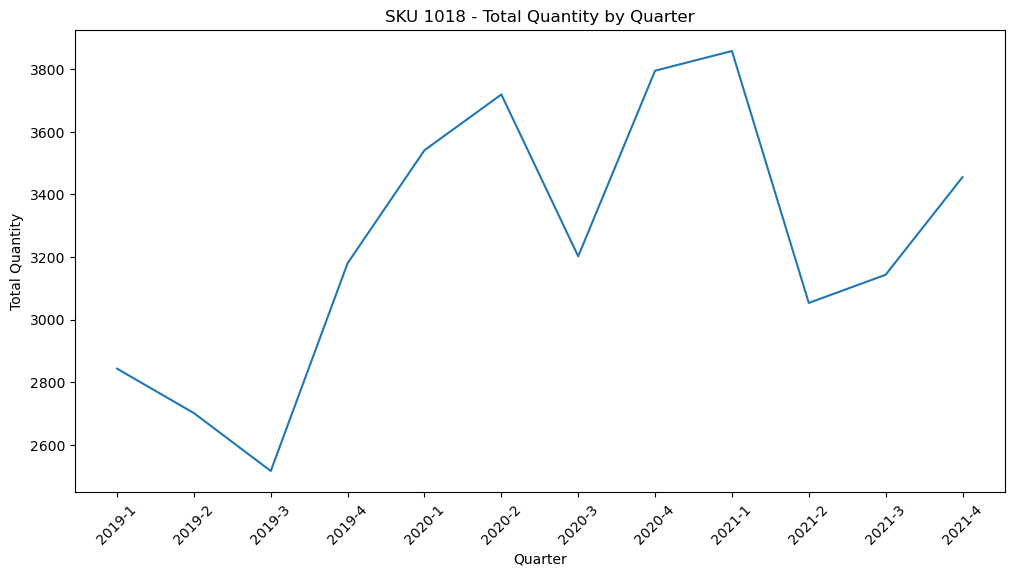

SKU 1050


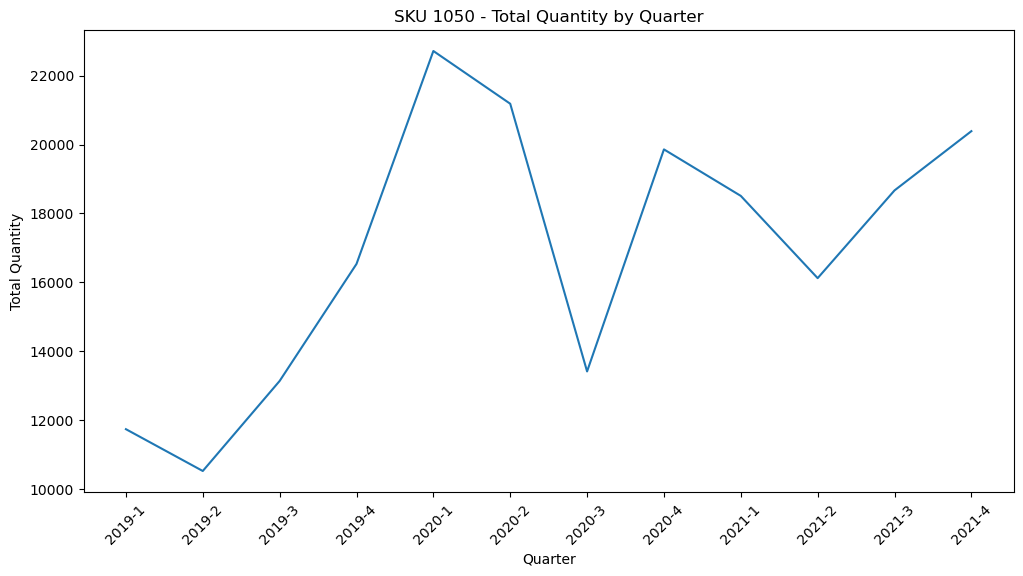

SKU 319


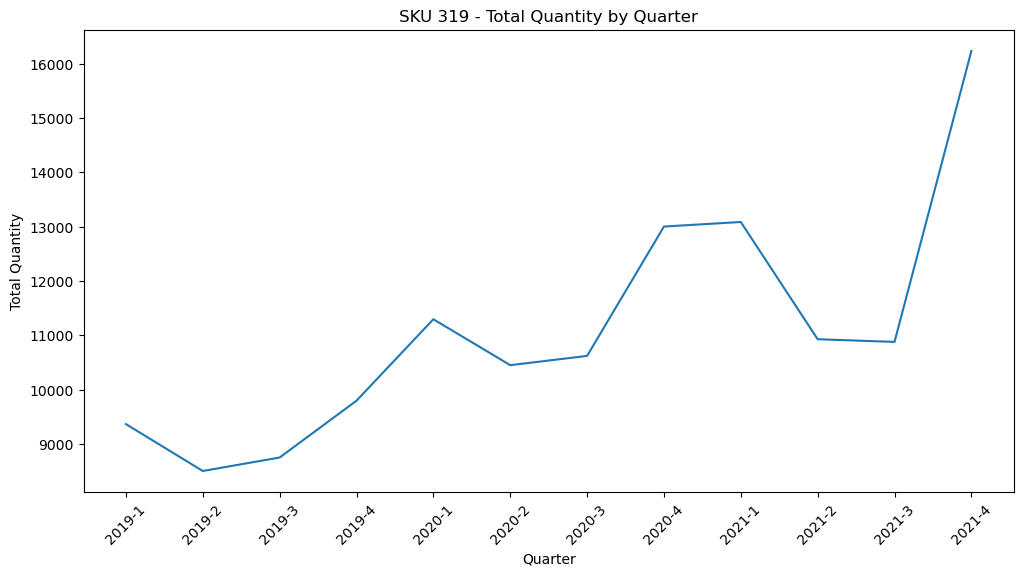

SKU 509


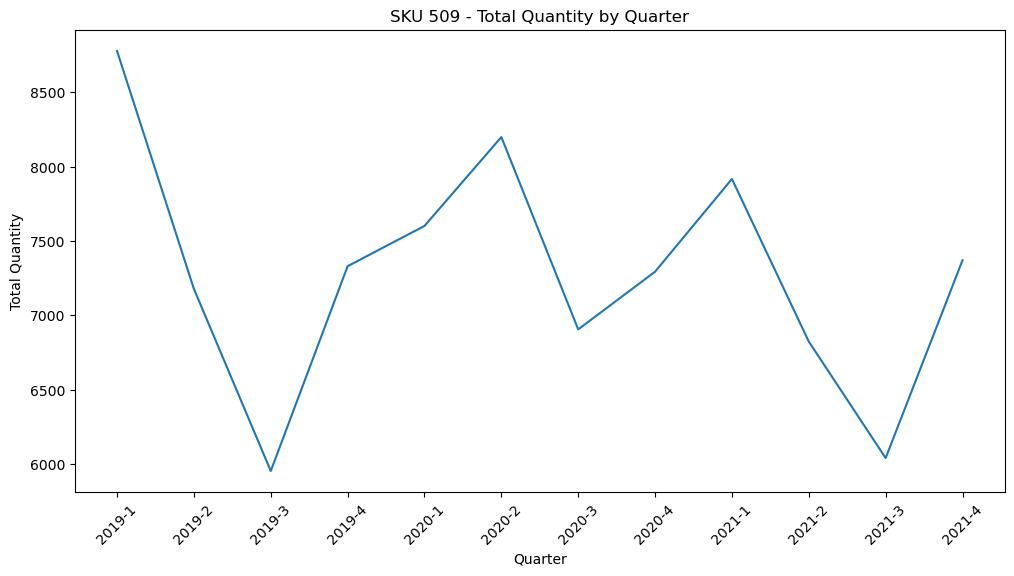

SKU 568


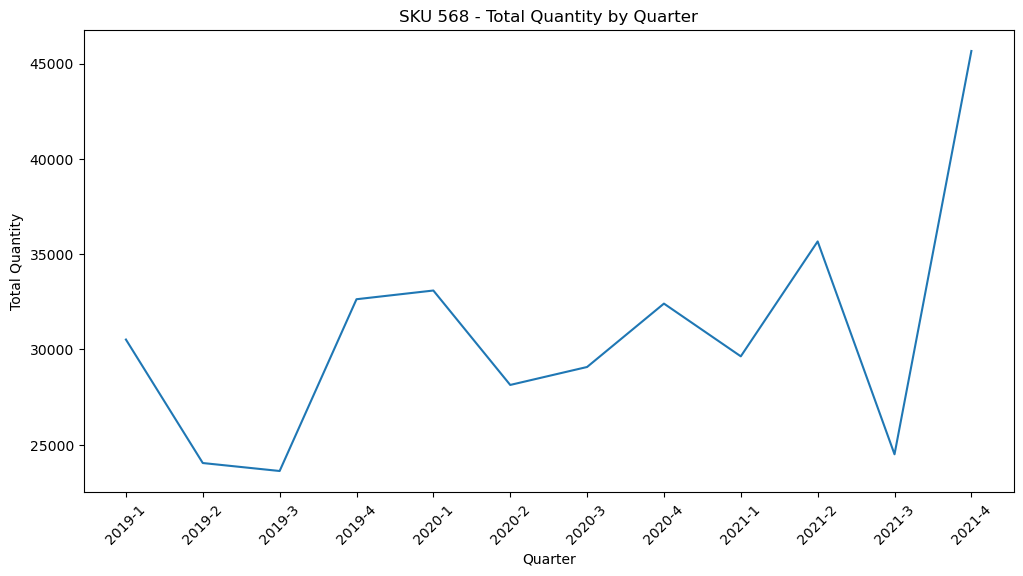

SKU 578


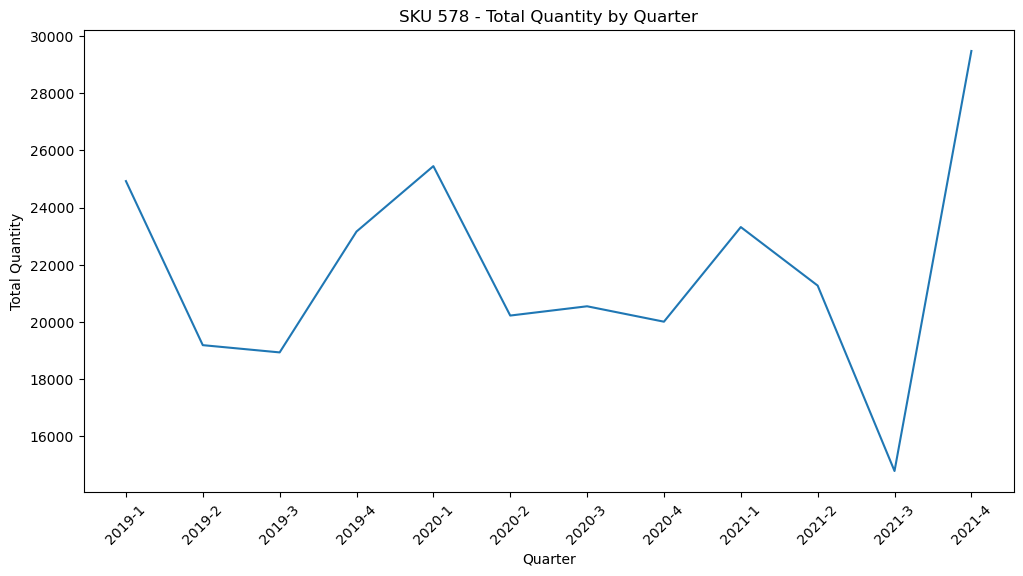

SKU 615


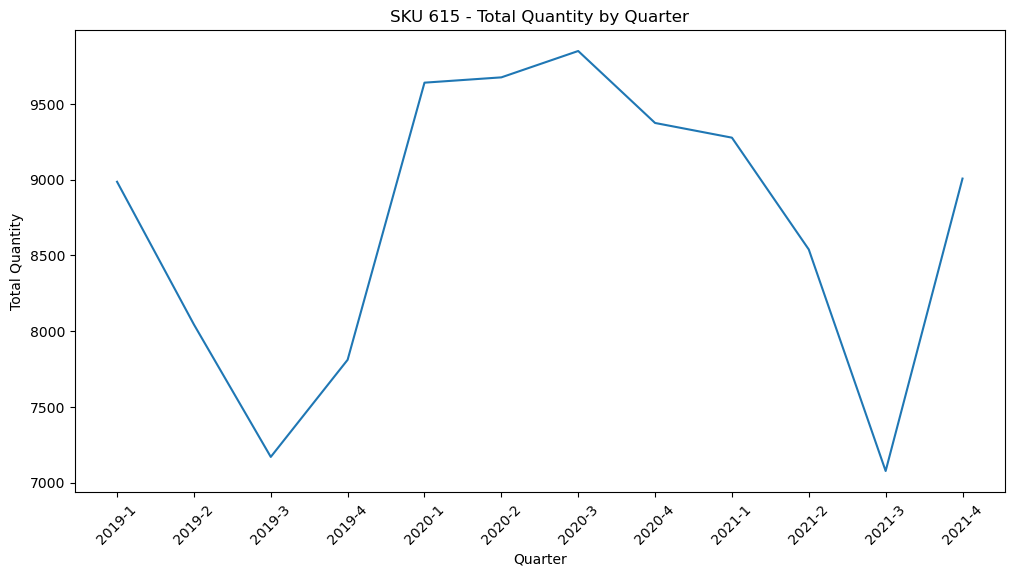

In [33]:
for sku in quarterly_data['SkuID'].unique():
    print(f'SKU {sku}')
    plot_total_quantity(sku, data=quarterly_data)

# R-squared Analysis

Calculate the R-squared value for each SKU to evaluate the model performance.

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

def analyze_feature_effects(df, test_size=0.2, random_state=42, additional_cols=None, time_cols=None):
    categorical_cols = []
    
    if time_cols is None:
        time_cols = ['Year', 'Quarter']
        
    if additional_cols is None:
        additional_cols = ['District']
        
    for col in additional_cols:
        if col not in df.columns:
            raise ValueError(f'Column "{col}" not found in the DataFrame.')
        
        # if the column is categorical or object, convert it to category data type
        if df[col].dtype.name in ['category', 'object']:
            df[col] = df[col].astype('category')
            categorical_cols.append(col)

    results = []

    for sku in df['SkuID'].unique():
        df_sku = df[df['SkuID'] == sku].copy()
        df_encoded = pd.get_dummies(df_sku, columns=categorical_cols)
        X = df_encoded.drop(['TotalQuantity', 'SkuID'] + time_cols, axis=1)
        y = df_encoded['TotalQuantity']

        if len(df_encoded) > 1:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
            model = LinearRegression()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            r2 = r2_score(y_test, y_pred)
            coefficients = dict(zip(X.columns, model.coef_))
            results.append((sku, round(r2, 3), coefficients))
        else:
            results.append((sku, None, None))

    return results

## Assigning the columns


In [35]:
df_cleaned_selected = df_cleaned.copy()
print(df_cleaned_selected.columns)

Index(['SkuID', 'MainDistID', 'District', 'SalesRegionID', 'Date', 'Year',
       'Quarter', 'Month', 'Week', 'TotalQuantity'],
      dtype='object')


In [36]:
time_cols = ['Year', 'Quarter']
additional_cols = ['District']

df_cleaned_selected = df_cleaned_selected.groupby(['SkuID'] +
    time_cols + additional_cols
).agg({'TotalQuantity': 'sum'}).reset_index()

print(df_cleaned_selected.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   SkuID          420 non-null    object
 1   Year           420 non-null    int64 
 2   Quarter        420 non-null    int64 
 3   District       420 non-null    object
 4   TotalQuantity  420 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 16.5+ KB
None


In [37]:
df_cleaned_selected

,SkuID,Year,Quarter,District,TotalQuantity
0,1018,2019,1,FATİH,510
1,1018,2019,1,GAZİOSMANPAŞA,655
2,1018,2019,1,KÜÇÜKÇEKMECE,612
3,1018,2019,1,PENDİK,661
4,1018,2019,1,ÜMRANİYE,405
...,...,...,...,...,...
415,615,2021,4,FATİH,1315
416,615,2021,4,GAZİOSMANPAŞA,1792
417,615,2021,4,KÜÇÜKÇEKMECE,1558
418,615,2021,4,PENDİK,2122


In [38]:
# Run the analysis for each SKU
results = analyze_feature_effects(df_cleaned_selected, additional_cols=additional_cols, time_cols=time_cols)

# Convert results to a DataFrame for better readability
results_df = pd.DataFrame(results, columns=['SkuID', 'R_squared', 'Coefficients'])
results_df

,SkuID,R_squared,Coefficients
0,1018,0.322,"{'District_FATİH': 5.068684034897636e+16, 'Dis..."
1,1050,0.051,"{'District_FATİH': -2.058617340338754e+17, 'Di..."
2,319,0.118,"{'District_FATİH': 7.084541945978876e+16, 'Dis..."
3,509,-0.156,"{'District_FATİH': -7.859735964536232e+16, 'Di..."
4,568,0.174,"{'District_FATİH': -5.890512623578943e+17, 'Di..."
5,578,0.120,"{'District_FATİH': 8.769318370698294e+16, 'Dis..."
6,615,0.251,"{'District_FATİH': 2.4787651853363146e+17, 'Di..."


### Interpretation for R-squared Analysis

Based on the R-squared analysis, the following columns are used for the analysis in addition to the time columns:

--------

#### 'Year', 'Quarter', 'District', 'MainDistID', 'DistID'
```python
time_cols = ['Year', 'Quarter']
additional_cols = ['District', 'MainDistID', 'DistID']
```

The R-squared values for each SKU are as follows:

| Index | SKU  | R_squared |
|-------|------|-----------|
| 0     | 1018 | 0.047     |
| 1     | 1050 | 0.050     |
| 2     | 319  | 0.053     |
| 3     | 509  | 0.052     |
| 4     | 568  | 0.054     |
| 5     | 578  | 0.045     |
| 6     | 615  | 0.046     |

### Observations
- **Consistent Scores:** Across all SKUs, the evaluation scores range from 0.045 to 0.054, indicating relatively consistent performance across the board.
- **Low Variability:** The evaluation scores do not exhibit significant variability, suggesting that the model performs similarly for different SKUs.

========


#### 'Year', 'Month', 'District', 'MainDistID'
```python
time_cols = ['Year', 'Month']
additional_cols = ['District', 'MainDistID']
```

| Index | SKU ID | Evaluation Score |
| --- | --- | --- |
| 0 | 1018 | 0.634 |
| 1 | 1050 | 0.622 |
| 2 | 319 | 0.844 |
| 3 | 509 | 0.780 |
| 4 | 568 | 0.677 |
| 5 | 578 | 0.556 |
| 6 | 615 | 0.659 |

### Interpretation
-   **High Evaluation Score**: SKU 319 has the highest evaluation score (0.844), indicating strong performance.
-   **Moderate Evaluation Scores**: SKUs 509, 568, 1018, and 615 have moderate evaluation scores ranging from 0.634 to 0.780.
-   **Lower Evaluation Scores**: SKUs 1050 and 578 have the lowest evaluation scores, with scores of 0.622 and 0.


#### 'Year', 'Quarter', 'District', 'MainDistID'
```python
time_cols = ['Year', 'Quarter']
additional_cols = ['District', 'MainDistID']
```

The R-squared values for each SKU are as follows:

| Index | SKU | R_squared |
| --- | --- | --- |
| 0 | 1018 | 0.816 |
| 1 | 1050 | 0.767 |
| 2 | 319 | 0.874 |
| 3 | 509 | 0.863 |
| 4 | 568 | 0.817 |
| 5 | 578 | 0.686 |
| 6 | 615 | 0.793 |

### Observations
- **Improved Scores:** The evaluation scores have significantly improved, ranging from 0.686 to 0.874, indicating better performance.
- **High Variability:** The evaluation scores exhibit more variability compared to the previous analysis, suggesting that the model's performance varies across different SKUs.
- **Top Performers:** SKUs 319 and 509 have the highest evaluation scores, indicating that the model performs exceptionally well for these SKUs.
- **SKU 578:** SKU 578 has the lowest evaluation score, suggesting that the model may not perform as effectively for this SKU.
- **Overall Performance:** The model performs well across most SKUs, with the majority of evaluation scores above 0.75, indicating a good fit to the data.

#### 'Year', 'Quarter', 'District', 'SalesRegionID'
```python
time_cols = ['Year', 'Quarter']
additional_cols = ['District', 'SalesRegionID']
```
1018,0.006
1050,0.009
319,0.011
509,0.010
568,0.010
578,0.006
615,0.008


In [39]:
import numpy as np

# Convert coefficients to a DataFrame for easier analysis
coefficients_df = pd.DataFrame()
coefficients_df['SkuID'] = results_df['SkuID']

for i, row in results_df.iterrows():
    coefficients = row['Coefficients']
    if coefficients is not None:
        for col, coef in coefficients.items():
            col_name = f'{col}'
            if col_name not in coefficients_df:
                coefficients_df[col_name] = np.nan
            coefficients_df.loc[i, col_name] = coef
        
coefficients_df    

,SkuID,District_FATİH,District_GAZİOSMANPAŞA,District_KÜÇÜKÇEKMECE,District_PENDİK,District_ÜMRANİYE
0,1018,5.068684e+16,5.068684e+16,5.068684e+16,5.068684e+16,5.068684e+16
1,1050,-2.058617e+17,-2.058617e+17,-2.058617e+17,-2.058617e+17,-2.058617e+17
2,319,7.084542e+16,7.084542e+16,7.084542e+16,7.084542e+16,7.084542e+16
3,509,-7.859736e+16,-7.859736e+16,-7.859736e+16,-7.859736e+16,-7.859736e+16
4,568,-5.890513e+17,-5.890513e+17,-5.890513e+17,-5.890513e+17,-5.890513e+17
5,578,8.769318e+16,8.769318e+16,8.769318e+16,8.769318e+16,8.769318e+16
6,615,2.478765e+17,2.478765e+17,2.478765e+17,2.478765e+17,2.478765e+17


<Figure size 1600x1000 with 0 Axes>

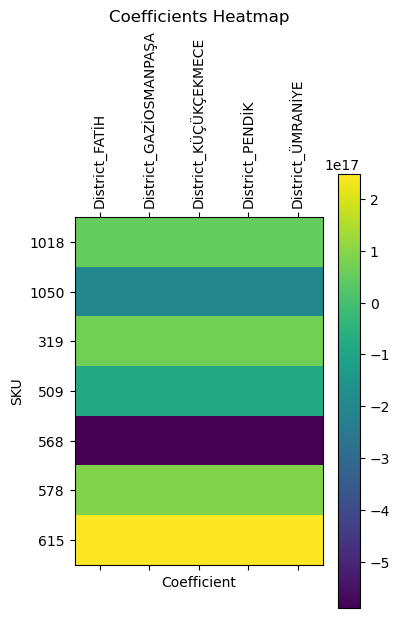

In [40]:
# heatmap for coefficients
plt.figure(figsize=(16, 10))
plt.matshow(coefficients_df.drop('SkuID', axis=1), cmap='viridis')
plt.colorbar()
plt.xticks(range(len(coefficients_df.columns) - 1), coefficients_df.columns[1:], rotation=90)
plt.yticks(range(len(coefficients_df)), coefficients_df['SkuID'])
plt.xlabel('Coefficient')
plt.ylabel('SKU')
plt.title('Coefficients Heatmap')
plt.show()

In [41]:
avg_maindistid_coefficients = coefficients_df.filter(regex='MainDistID').mean()

avg_maindistid_coefficients_df = pd.DataFrame(avg_maindistid_coefficients, columns=['Average Coefficient'])

print('Average Coefficients for MainDistID:')
avg_maindistid_coefficients_df

Average Coefficients for MainDistID:


,Average Coefficient


In [42]:
avg_district_coefficients = coefficients_df.filter(regex='District').mean()

avg_district_coefficients_df = pd.DataFrame(avg_district_coefficients, columns=['Average Coefficient'])

print('Average Coefficients for District:')
avg_district_coefficients_df

Average Coefficients for District:


,Average Coefficient
District_FATİH,-5.948691e+16
District_GAZİOSMANPAŞA,-5.948691e+16
District_KÜÇÜKÇEKMECE,-5.948691e+16
District_PENDİK,-5.948691e+16
District_ÜMRANİYE,-5.948691e+16


In [57]:
avg_distid_coefficients = coefficients_df.filter(regex='DistID').mean()

avg_distid_coefficients_df = pd.DataFrame(avg_distid_coefficients, columns=['Average Coefficient'])

print('Average Coefficients for DistID:')
avg_distid_coefficients_df

Average Coefficients for DistID:


,Average Coefficient


# Forecasting

In [121]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

def forecast_total_quantity_seasonal(df, time_range, district, skuid):
    grupBY = ['SkuID', 'Year']
    
    if skuid is None:
        raise ValueError("SKU ID cannot be None.")
    
    if district is None:
        df_filtered = df[df['SkuID'] == skuid]
    else:
        df_filtered = df[(df['District'] == district) & (df['SkuID'] == skuid)]
        grupBY.append('District')
    
    # Aggregate data based on the time range
    if time_range == 'Quarter':
        df_agg = df_filtered.groupby(grupBY + ["Quarter"]).agg({'TotalQuantity': 'sum'}).reset_index()
        df_agg['Date'] = pd.to_datetime(df_agg['Year'].astype(str) + 'Q' + df_agg['Quarter'].astype(str))
        df_agg.set_index('Date', inplace=True)
        df_agg.index.freq = pd.infer_freq(df_agg.index)
        seasonal_periods = 4
        
    elif time_range == 'Month':
        df_agg = df_filtered.groupby(grupBY + ['Month']).agg({'TotalQuantity': 'sum'}).reset_index()
        df_agg['Date'] = pd.to_datetime(df_agg['Year'].astype(str) + df_agg['Month'].astype(str).str.zfill(2), format='%Y%m')
        df_agg.set_index('Date', inplace=True)
        df_agg.index.freq = pd.infer_freq(df_agg.index)
        seasonal_periods = 12
        
    elif time_range == 'Week':
        df_agg = df_filtered.groupby(grupBY + ['Week']).agg({'TotalQuantity': 'sum'}).reset_index()
        df_agg['Date'] = pd.to_datetime(df_agg['Year'].astype(str) + df_agg['Week'].astype(str).str.zfill(2) + '0', format='%Y%W%w')
        df_agg.set_index('Date', inplace=True)
        df_agg.index.freq = pd.infer_freq(df_agg.index)
        seasonal_periods = 52
        
    else:
        raise ValueError("Invalid time range. Choose from 'Quarter', 'Month', or 'Week'.")
    
    # Split the data into train and test sets
    train = df_agg.iloc[:-seasonal_periods]
    test = df_agg.iloc[-seasonal_periods:]
    
    # Define the models
    models = {
        'Exponential Smoothing': ExponentialSmoothing(train['TotalQuantity'], seasonal='add', seasonal_periods=seasonal_periods),
        'Moving Average': ARIMA(train['TotalQuantity'], order=(0, 0, 1)),
        'Naive': ARIMA(train['TotalQuantity'], order=(0, 0, 0)),
        'Triple Exponential Smoothing': ExponentialSmoothing(train['TotalQuantity'], seasonal='add', seasonal_periods=seasonal_periods, trend='add'),
        'ARIMA': ARIMA(train['TotalQuantity'], order=(1, 1, 1)),
        'SARIMA': SARIMAX(train['TotalQuantity'], order=(1, 1, 1), seasonal_order=(1, 1, 1, seasonal_periods))
    }
    
    forecasts = {}
    metrics = {}
    
    for name, model in models.items():
        try:
            fit_model = model.fit()
            forecast = fit_model.forecast(steps=seasonal_periods)
            forecasts[name] = forecast
            
            mape = mean_absolute_percentage_error(test['TotalQuantity'], forecast)
            mse = mean_squared_error(test['TotalQuantity'], forecast)
            rmse = np.sqrt(mse)
            mad = mean_absolute_error(test['TotalQuantity'], forecast)
            
            metrics[name] = {
                'MAPE': mape,
                'MSE': mse,
                'RMSE': rmse,
                'MAD': mad
            }
        except Exception as e:
            print(f"Failed to fit {name} model: {e}")
            forecasts[name] = np.nan
            metrics[name] = {
                'MAPE': np.nan,
                'MSE': np.nan,
                'RMSE': np.nan,
                'MAD': np.nan
            }
    
    return forecasts, metrics

# Results for Forecasting

### Iterating over each SKU and Time Range

This function iterates over a list of SKU IDs, performs forecasting for each SKU over specified time ranges, collects the forecast performance metrics, and stores them in a DataFrame. Here's a detailed breakdown of the function:

1.  **Initialization**:

    -   `metrics_df_by_sku` is initialized as an empty list. This will later hold dictionaries with performance metrics for each SKU.
2.  **Iterating Over SKUs**:

    -   The function assumes `all_sku_ids` is a predefined list of SKU IDs.
    -   It iterates over each SKU in `all_sku_ids`.
3.  **Logging**:

    -   For each SKU, a message is printed indicating the start of forecasting for that SKU.
4.  **Iterating Over Time Ranges**:
    -   Inside the SKU loop, it iterates over a list of time ranges (in this case, just `['Quarter']` but you can add also `['Month', 'Week']`).
    -   For each time range, a message is printed indicating the start of forecasting for that time range.
5.  **Forecasting and Metric Collection**:

    -   The `forecast_total_quantity_seasonal` function is called with the cleaned data frame (`df_cleaned`), the current time range, `None` for a placeholder parameter (possibly indicating no specific district), and the current SKU.
    -   This function returns forecasts and metrics. The exact structure of `metrics` isn't specified, but it is assumed to be a dictionary where each key is a model name and each value is another dictionary containing the performance metrics (`MAPE`, `MSE`, `RMSE`, `MAD`).
6.  **Appending Metrics**:

    -   For each model in the `metrics` dictionary, the function constructs a dictionary with the following key-value pairs:
        -   `SKU`: The current SKU.
        -   `District`: Set to `'All'` (indicating metrics for all districts).
        -   `Time Range`: The current time range.
        -   `Model`: The model name.
        -   `MAPE`, `MSE`, `RMSE`, `MAD`: The respective performance metrics for the model.
    -   This dictionary is appended to the `metrics_df_by_sku` list.
7.  **Converting to DataFrame**:

    -   After processing all SKUs and time ranges, `metrics_df_by_sku` (a list of dictionaries) is converted into a Pandas DataFrame.

In [123]:
metrics_df_by_sku = []

# Assuming all_sku_ids is a list of SKU IDs available
for sku in all_sku_ids:
    print(f'Forecasting for SKU {sku}')
        
    for time_range in ['Quarter']:
        print(f'Forecasting for Time Range: {time_range}')
        forecasts, metrics = forecast_total_quantity_seasonal(df_cleaned, time_range, None, sku)
        
        for model, metric in metrics.items():
            metrics_df_by_sku.append({
                'SKU': sku,
                'District': 'All',
                'Time Range': time_range,
                'Model': model,
                'MAPE': metric['MAPE'],
                'MSE': metric['MSE'],
                'RMSE': metric['RMSE'],
                'MAD': metric['MAD']
            })
                
metrics_df_by_sku = pd.DataFrame(metrics_df_by_sku)

Forecasting for SKU 568
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.60496D+00    |proj g|=  8.14077D-01

At iterate    5    f=  3.36630D+00    |proj g|=  3.27089D-02

At iterate   10    f=  3.34859D+00    |proj g|=  3.45289D-02

At iterate   15    f=  3.34583D+00    |proj g|=  1.93722D-02

At iterate   20    f=  3.34540D+00    |proj g|=  2.60518D-04

At iterate   25    f=  3.34540D+00    |proj g|=  1.44957D-03

At iterate   30    f=  3.34515D+00    |proj g|=  1.32827D-02

At iterate   35    f=  3.33749D+00    |proj g|=  6.77256D-02

At iterate   40    f=  3.17001D+00    |proj g|=  6.29838D-01

At iterate   45    f=  3.04723D+00    |proj g|=  1.48054D-02

At iterate   50    f=  3.04628D+00    |proj g|=  2.24185D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function eval

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.53575D+00    |proj g|=  5.09590D-01

At iterate    5    f=  3.31456D+00    |proj g|=  7.47439D-02

At iterate   10    f=  3.28721D+00    |proj g|=  1.84080D-02

At iterate   15    f=  3.28616D+00    |proj g|=  3.02451D-04

At iterate   20    f=  3.28616D+00    |proj g|=  6.21226D-04

At iterate   25    f=  3.28608D+00    |proj g|=  8.83991D-03

At iterate   30    f=  3.27320D+00    |proj g|=  9.35649D-02

At iterate   35    f=  3.17428D+00    |proj g|=  1.91843D-02

At iterate   40    f=  3.16934D+00    |proj g|=  5.28202D-03

At iterate   45    f=  3.16696D+00    |proj g|=  1.75912D-03

At iterate   50    f=  3.16673D+00    |proj g|=  3.42727D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


At iterate   20    f=  3.68176D+00    |proj g|=  4.88533D-04

At iterate   25    f=  3.68151D+00    |proj g|=  1.90995D-03

At iterate   30    f=  3.68140D+00    |proj g|=  2.25920D-04

At iterate   35    f=  3.66370D+00    |proj g|=  1.70641D-02

At iterate   40    f=  3.65905D+00    |proj g|=  5.80048D-02

At iterate   45    f=  3.65235D+00    |proj g|=  2.26693D-03

At iterate   50    f=  3.65231D+00    |proj g|=  4.60382D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50    110      3     0     0   4.604D-03   3.652D+00
  F =   3.6523073569272357     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT        


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.07509D+00    |proj g|=  1.29751D-01

At iterate    5    f=  2.86824D+00    |proj g|=  3.92563D-02

At iterate   10    f=  2.85598D+00    |proj g|=  8.20942D-03

At iterate   15    f=  2.85523D+00    |proj g|=  4.96145D-04

At iterate   20    f=  2.85520D+00    |proj g|=  1.22198D-03

At iterate   25    f=  2.84041D+00    |proj g|=  3.00049D-02

At iterate   30    f=  2.75828D+00    |proj g|=  6.21283D-02

At iterate   35    f=  2.74182D+00    |proj g|=  7.31898D-03

At iterate   40    f=  2.74075D+00    |proj g|=  6.62944D-04

At iterate   45    f=  2.74015D+00    |proj g|=  1.28913D-03

At iterate   50    f=  2.73959D+00    |proj g|=  5.66165D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26094D+00    |proj g|=  7.97592D-01

At iterate    5    f=  3.01513D+00    |proj g|=  1.21440D-02

At iterate   10    f=  3.01198D+00    |proj g|=  9.02504D-04

At iterate   15    f=  3.01197D+00    |proj g|=  2.56509D-03

At iterate   20    f=  3.01126D+00    |proj g|=  2.57042D-02

At iterate   25    f=  2.95486D+00    |proj g|=  3.15177D-01

At iterate   30    f=  2.76220D+00    |proj g|=  4.58945D-03

At iterate   35    f=  2.76161D+00    |proj g|=  1.22993D-02

At iterate   40    f=  2.76113D+00    |proj g|=  6.71454D-03

At iterate   45    f=  2.76054D+00    |proj g|=  1.07008D-02

At iterate   50    f=  2.76034D+00    |proj g|=  1.78601D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate    5    f=  2.96654D+00    |proj g|=  2.78295D-02

At iterate   10    f=  2.96319D+00    |proj g|=  1.15519D-03

At iterate   15    f=  2.96317D+00    |proj g|=  1.98488D-03

At iterate   20    f=  2.96191D+00    |proj g|=  9.38278D-03

At iterate   25    f=  2.90523D+00    |proj g|=  1.52483D-01

At iterate   30    f=  2.85503D+00    |proj g|=  1.15727D-02

At iterate   35    f=  2.84902D+00    |proj g|=  4.60346D-03

At iterate   40    f=  2.84684D+00    |proj g|=  6.13656D-03

At iterate   45    f=  2.84591D+00    |proj g|=  6.29740D-03

At iterate   50    f=  2.84530D+00    |proj g|=  2.85938D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Forecasting Metrics without District

The following table shows the forecast metrics for each SKU based on the different forecasting models and time ranges.

In [124]:
metrics_df_by_sku.set_index(['SKU', 'Time Range', 'Model'], inplace=True)
metrics_df_by_sku.drop(columns=['District'], inplace=True)

In [125]:
metrics_df_by_sku

MAPE           MSE  \
SKU  Time Range Model                                                  
568  Quarter    Exponential Smoothing         0.181153  6.755216e+07   
                Moving Average                0.198347  8.313566e+07   
                Naive                         0.187203  8.383000e+07   
                Triple Exponential Smoothing  0.198658  4.275218e+07   
                ARIMA                         0.194756  6.698241e+07   
                SARIMA                        0.480079  2.434221e+08   
578  Quarter    Exponential Smoothing         0.184870  1.937678e+07   
                Moving Average                0.189762  2.725725e+07   
                Naive                         0.204302  2.803318e+07   
                Triple Exponential Smoothing  0.186335  1.968793e+07   
                ARIMA                         0.233208  4.556848e+07   
                SARIMA                        0.534866  1.211018e+08   
1050 Quarter    Exponential Smoothing         0.109045  6.724745e+06   
                Moving Average                0.128778  8.304079e+06   
                Naive                         0.118202  7.512343e+06   
                Triple Exponential Smoothing  0.438360  7.894260e+07   
                ARIMA                         0.075534  2.754697e+06   
                SARIMA                        0.695907  1.669704e+08   
319  Quarter    Exponential Smoothing         0.100199  3.214968e+06   
                Moving Average                0.133340  8.935397e+06   
                Naive                         0.178415  1.130914e+07   
                Triple Exponential Smoothing  0.139777  3.208807e+06   
                ARIMA                         0.175987  5.706190e+06   
                SARIMA                        0.072100  1.203816e+06   
509  Quarter    Exponential Smoothing         0.062519  2.999637e+05   
                Moving Average                0.093445  5.806530e+05   
                Naive                         0.095164  6.165530e+05   
                Triple Exponential Smoothing  0.087752  4.692688e+05   
                ARIMA                         0.089721  4.980598e+05   
                SARIMA                        0.190831  1.891128e+06   
615  Quarter    Exponential Smoothing         0.183079  2.690640e+06   
                Moving Average                0.090830  8.857458e+05   
                Naive                         0.087292  8.392601e+05   
                Triple Exponential Smoothing  0.319406  7.254559e+06   
                ARIMA                         0.096612  1.203082e+06   
                SARIMA                        0.569904  2.270718e+07   
1018 Quarter    Exponential Smoothing         0.095115  1.562866e+05   
                Moving Average                0.060870  6.030918e+04   
                Naive                         0.077349  1.354417e+05   
                Triple Exponential Smoothing  0.287383  9.878386e+05   
                ARIMA                         0.122413  1.934346e+05   
                SARIMA                        0.308956  1.119801e+06   

                                                      RMSE           MAD  
SKU  Time Range Model                                                     
568  Quarter    Exponential Smoothing          8219.012161   6805.820128  
                Moving Average                 9117.875930   7321.178272  
                Naive                          9155.872604   7020.562500  
                Triple Exponential Smoothing   6538.515215   6455.845026  
                ARIMA                          8184.278460   6799.386751  
                SARIMA                        15601.989856  14161.597746  
578  Quarter    Exponential Smoothing          4401.906524   3798.328687  
                Moving Average                 5220.847446   3840.784999  
                Naive                          5294.636593   4191.250000  
                Triple Exponential Smoothing   4437.1078

### Iterating over each SKU, District, and Time Range

In [126]:
metrics_df_by_district = []

# Iterate over each SKU, District, and Time Range
for sku in all_sku_ids:
    print(f'Forecasting for SKU {sku}')
    
    for district in highest_districts:
        print(f'Forecasting for District {district}')
        
        for time_range in ['Quarter']:
            print(f'Forecasting for Time Range: {time_range}')
            
            forecasts, metrics = forecast_total_quantity_seasonal(df_cleaned, time_range, district, sku)
            
            for model, metric in metrics.items():
                metrics_df_by_district.append({
                    'SKU': sku,
                    'District': district,
                    'Time Range': time_range,
                    'Model': model,
                    'MAPE': metric['MAPE'],
                    'MSE': metric['MSE'],
                    'RMSE': metric['RMSE'],
                    'MAD': metric['MAD']
                })
                
metrics_df_by_district = pd.DataFrame(metrics_df_by_district)

Forecasting for SKU 568
Forecasting for District PENDİK
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.03269D+00    |proj g|=  9.86213D-02

At iterate    5    f=  2.84415D+00    |proj g|=  3.39363D-02

At iterate   10    f=  2.82963D+00    |proj g|=  2.39213D-02

At iterate   15    f=  2.82539D+00    |proj g|=  7.26846D-03

At iterate   20    f=  2.82470D+00    |proj g|=  2.49241D-04

At iterate   25    f=  2.82469D+00    |proj g|=  1.46437D-04

At iterate   30    f=  2.82466D+00    |proj g|=  1.95777D-05


 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   35    f=  2.82466D+00    |proj g|=  5.34079D-05

At iterate   40    f=  2.82466D+00    |proj g|=  6.83873D-04

At iterate   45    f=  2.82437D+00    |proj g|=  4.98222D-03

At iterate   50    f=  2.82418D+00    |proj g|=  3.31667D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     60      1     0     0   3.317D-03   2.824D+00
  F =   2.8241835908451107     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Forecasting for District GAZİOSMANPAŞA
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.30180D+00    |proj g|=  4.20487D-01

At iterate    5    f=  3.08141D+00    |proj g|=  2.64052D-02

At iterate   10    f=  3.07357D+00    |proj g|=  1.98850D-04

At iterate   15    f=  3.07351D+00    |proj g|=  1.70885D-03

At iterate   20    f=  3.07016D+00    |proj g|=  2.65473D-02

At iterate   25    f=  2.98230D+00    |proj g|=  2.93540D-01

At iterate   30    f=  2.91610D+00    |proj g|=  2.44760D-02

At iterate   35    f=  2.91123D+00    |proj g|=  4.80705D-03

At iterate   40    f=  2.90942D+00    |proj g|=  2.81443D-04

At iterate   45    f=  2.90467D+00    |proj g|=  4.76323D-04

At iterate   50    f=  2.90461D+00    |proj g|=  1.99896D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  3.13247D+00    |proj g|=  2.16161D-02

At iterate   10    f=  3.12494D+00    |proj g|=  1.77389D-03

At iterate   15    f=  3.12493D+00    |proj g|=  5.57850D-04

At iterate   20    f=  3.12483D+00    |proj g|=  6.36496D-03

At iterate   25    f=  3.11881D+00    |proj g|=  3.06173D-02

At iterate   30    f=  2.84673D+00    |proj g|=  3.06578D-01

At iterate   35    f=  2.72490D+00    |proj g|=  1.37573D-01

At iterate   40    f=  2.68804D+00    |proj g|=  2.54466D-02

At iterate   45    f=  2.67915D+00    |proj g|=  4.48536D-02

At iterate   50    f=  2.67488D+00    |proj g|=  1.41184D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  3.01111D+00    |proj g|=  7.23618D-02

At iterate   10    f=  2.96667D+00    |proj g|=  4.99468D-03

At iterate   15    f=  2.96551D+00    |proj g|=  2.08428D-04

At iterate   20    f=  2.96540D+00    |proj g|=  3.81697D-04

At iterate   25    f=  2.96540D+00    |proj g|=  2.90613D-05

At iterate   30    f=  2.96540D+00    |proj g|=  6.10937D-04

At iterate   35    f=  2.96509D+00    |proj g|=  8.55838D-03

At iterate   40    f=  2.96462D+00    |proj g|=  7.15290D-04

At iterate   45    f=  2.96457D+00    |proj g|=  2.85742D-04

At iterate   50    f=  2.96456D+00    |proj g|=  6.86368D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f=  3.04648D+00    |proj g|=  3.13934D-02

Forecasting for District GAZİOSMANPAŞA
Forecasting for Time Range: Quarter
At iterate   15    f=  3.02791D+00    |proj g|=  1.35323D-02

At iterate   20    f=  3.01235D+00    |proj g|=  7.07864D-03

At iterate   25    f=  3.01056D+00    |proj g|=  1.38300D-03

At iterate   30    f=  3.01040D+00    |proj g|=  1.59460D-04

At iterate   35    f=  3.01035D+00    |proj g|=  1.99248D-03

At iterate   40    f=  2.96526D+00    |proj g|=  1.24348D-01

At iterate   45    f=  2.94619D+00    |proj g|=  1.20492D-02

At iterate   50    f=  2.93939D+00    |proj g|=  5.95777D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N 

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f=  3.05051D+00    |proj g|=  1.26307D-03

At iterate   15    f=  3.05043D+00    |proj g|=  5.38656D-04

At iterate   20    f=  3.05021D+00    |proj g|=  6.88427D-03

At iterate   25    f=  3.02433D+00    |proj g|=  5.76973D-02

At iterate   30    f=  2.83193D+00    |proj g|=  2.41540D-01

At iterate   35    f=  2.72640D+00    |proj g|=  2.48319D-02

At iterate   40    f=  2.69471D+00    |proj g|=  3.48307D-02

At iterate   45    f=  2.67757D+00    |proj g|=  5.03939D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     47     72      1     0     0   6.522D-03   2.675D+00
  F =   2.67474818598

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   15    f=  3.19726D+00    |proj g|=  1.65243D-04

At iterate   20    f=  3.19722D+00    |proj g|=  1.91887D-03

At iterate   25    f=  3.17685D+00    |proj g|=  6.82645D-02

At iterate   30    f=  2.96909D+00    |proj g|=  1.92678D-02

At iterate   35    f=  2.95723D+00    |proj g|=  8.75633D-03

At iterate   40    f=  2.95350D+00    |proj g|=  4.68982D-03

At iterate   45    f=  2.95168D+00    |proj g|=  7.95812D-03

At iterate   50    f=  2.95109D+00    |proj g|=  4.49935D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     64      1     0     0   4.499D-03   2.951D+00
  F =   2.95109140073

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   40    f=  2.73450D+00    |proj g|=  5.76971D-03

At iterate   45    f=  2.73338D+00    |proj g|=  5.38256D-03

At iterate   50    f=  2.73295D+00    |proj g|=  2.36939D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     57      1     0     0   2.369D-03   2.733D+00
  F =   2.7329529253531506     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Forecasting for SKU 1050
Forecasting for District PENDİK
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   40    f=  3.02765D+00    |proj g|=  6.65917D-04

At iterate   45    f=  3.02764D+00    |proj g|=  8.06987D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     82      1     0     0   8.070D-04   3.028D+00
  F =   3.0276408584888337     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Forecasting for District GAZİOSMANPAŞA
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.53162D+00    |proj g|=  2.81896

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   35    f=  3.36155D+00    |proj g|=  2.80602D-03

At iterate   40    f=  3.36145D+00    |proj g|=  3.27856D-03

At iterate   45    f=  3.35982D+00    |proj g|=  2.81522D-03

At iterate   50    f=  3.35937D+00    |proj g|=  3.51373D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     74      1     0     0   3.514D-04   3.359D+00
  F =   3.3593734282666592     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Forecasting for District KÜÇÜKÇEKMECE
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M = 

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  3.16844D+00    |proj g|=  5.80926D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     58      1     0     0   5.809D-05   3.168D+00
  F =   3.1684431880138959     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Forecasting for District ÜMRANİYE
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.03613D+00    |proj g|=  1.69090D-01

At iterate    5    f=  2.99314D+00    |proj g|=  1.86305D-02


/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   20    f=  2.93677D+00    |proj g|=  3.46451D-03

At iterate   25    f=  2.92144D+00    |proj g|=  2.06225D-02

At iterate   30    f=  2.89385D+00    |proj g|=  1.16234D-02

At iterate   35    f=  2.88926D+00    |proj g|=  1.21840D-03

At iterate   40    f=  2.88823D+00    |proj g|=  1.60521D-03

At iterate   45    f=  2.88767D+00    |proj g|=  9.62079D-04

At iterate   50    f=  2.88743D+00    |proj g|=  7.59660D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     61      1     0     0   7.597D-04   2.887D+00
  F =   2.8874322846783116     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


Forecasting for District GAZİOSMANPAŞA
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.71479D+00    |proj g|=  3.38977D-01

At iterate    5    f=  2.54269D+00    |proj g|=  3.51712D-02

At iterate   10    f=  2.52163D+00    |proj g|=  1.14766D-02

At iterate   15    f=  2.51905D+00    |proj g|=  5.94315D-04

At iterate   20    f=  2.51831D+00    |proj g|=  2.63175D-03

At iterate   25    f=  2.50051D+00    |proj g|=  1.08331D-03

At iterate   30    f=  2.50043D+00    |proj g|=  1.46109D-03

At iterate   35    f=  2.49704D+00    |proj g|=  1.15279D-02

At iterate   40    f=  2.49428D+00    |proj g|=  5.24576D-03

At iterate   45    f=  2.49100D+00    |proj g|=  3.90756D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explor

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   45    f=  2.26736D+00    |proj g|=  7.98202D-05

At iterate   50    f=  2.26656D+00    |proj g|=  9.82011D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     73      1     0     0   9.820D-04   2.267D+00
  F =   2.2665649415808553     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Forecasting for District ÜMRANİYE
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.66946D+00    |proj g|=  5.08215D-02


/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   25    f=  2.54165D+00    |proj g|=  4.73228D-03

At iterate   30    f=  2.50974D+00    |proj g|=  2.46888D-02

At iterate   35    f=  2.49570D+00    |proj g|=  1.07598D-02

At iterate   40    f=  2.49117D+00    |proj g|=  2.30768D-03

At iterate   45    f=  2.48992D+00    |proj g|=  1.83031D-03

At iterate   50    f=  2.48940D+00    |proj g|=  4.42135D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     77      1     0     0   4.421D-04   2.489D+00
  F =   2.4893977540763315     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Forecasting for SKU 509
Forecasting for District PE

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   20    f=  2.58268D+00    |proj g|=  3.15280D-03

At iterate   25    f=  2.58248D+00    |proj g|=  1.91223D-04

At iterate   30    f=  2.58245D+00    |proj g|=  2.10626D-04

At iterate   35    f=  2.58142D+00    |proj g|=  1.22138D-02

At iterate   40    f=  2.57300D+00    |proj g|=  2.92697D-03

At iterate   45    f=  2.57164D+00    |proj g|=  5.87518D-03

At iterate   50    f=  2.57092D+00    |proj g|=  5.36251D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     60      1     0     0   5.363D-03   2.571D+00
  F =   2.5709202600710590     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   35    f=  2.50193D+00    |proj g|=  7.97835D-03

At iterate   40    f=  2.50155D+00    |proj g|=  5.19278D-03

At iterate   45    f=  2.50136D+00    |proj g|=  2.37488D-03

At iterate   50    f=  2.50125D+00    |proj g|=  2.49937D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     63      1     0     0   2.499D-03   2.501D+00
  F =   2.5012490297057202     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Forecasting for District KÜÇÜKÇEKMECE
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M = 

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.70504D+00    |proj g|=  1.03360D-01

At iterate    5    f=  2.60245D+00    |proj g|=  3.05748D-03

At iterate   10    f=  2.60185D+00    |proj g|=  1.18712D-03

At iterate   15    f=  2.59664D+00    |proj g|=  1.84601D-02

At iterate   20    f=  2.50312D+00    |proj g|=  3.87693D-02

At iterate   25    f=  2.46918D+00    |proj g|=  3.36286D-02

At iterate   30    f=  2.45996D+00    |proj g|=  4.79374D-03

At iterate   35    f=  2.45654D+00    |proj g|=  4.21744D-03

At iterate   40    f=  2.45532D+00    |proj g|=  1.33817D-03

At iterate   45    f=  2.45469D+00    |proj g|=  2.79430D-04

At iterate   50    f=  2.45449D+00    |proj g|=  1.02636D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.82994D+00    |proj g|=  1.36231D-01

At iterate    5    f=  2.69386D+00    |proj g|=  6.55226D-03

At iterate   10    f=  2.69300D+00    |proj g|=  1.71639D-03

At iterate   15    f=  2.68412D+00    |proj g|=  2.62778D-02

At iterate   20    f=  2.58683D+00    |proj g|=  7.32312D-02

At iterate   25    f=  2.56135D+00    |proj g|=  7.51245D-03

At iterate   30    f=  2.56025D+00    |proj g|=  1.00724D-03

At iterate   35    f=  2.55950D+00    |proj g|=  9.43196D-04

At iterate   40    f=  2.55938D+00    |proj g|=  1.79902D-04

At iterate   45    f=  2.55936D+00    |proj g|=  7.03221D-05

At iterate   50    f=  2.55935D+00    |proj g|=  1.82706D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.69676D+00    |proj g|=  8.66324D-02

At iterate    5    f=  2.63190D+00    |proj g|=  3.61628D-03

At iterate   10    f=  2.63152D+00    |proj g|=  1.74130D-03

At iterate   15    f=  2.63023D+00    |proj g|=  4.95961D-03

At iterate   20    f=  2.62005D+00    |proj g|=  9.45028D-03

At iterate   25    f=  2.61944D+00    |proj g|=  2.43994D-04

At iterate   30    f=  2.61937D+00    |proj g|=  7.69972D-05

At iterate   35    f=  2.61936D+00    |proj g|=  1.04181D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  2.70589D+00    |proj g|=  3.51283D-03

At iterate   30    f=  2.70238D+00    |proj g|=  1.09830D-02

At iterate   35    f=  2.69968D+00    |proj g|=  7.25883D-03

At iterate   40    f=  2.69904D+00    |proj g|=  6.46067D-03

At iterate   45    f=  2.69886D+00    |proj g|=  3.17664D-03

At iterate   50    f=  2.69876D+00    |proj g|=  3.62085D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     71      1     0     0   3.621D-03   2.699D+00
  F =   2.6987577171286743     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Forecasting for District FATİH
Forecasting for Time

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.22298D+00    |proj g|=  2.68531D-01

At iterate    5    f=  2.13800D+00    |proj g|=  4.60374D-03

At iterate   10    f=  2.13740D+00    |proj g|=  1.47491D-03

At iterate   15    f=  2.13001D+00    |proj g|=  2.49359D-02

At iterate   20    f=  2.11796D+00    |proj g|=  1.39637D-02

At iterate   25    f=  2.11345D+00    |proj g|=  8.87510D-03

At iterate   30    f=  2.11245D+00    |proj g|=  2.50644D-03

At iterate   35    f=  2.11196D+00    |proj g|=  4.00393D-03

At iterate   40    f=  2.11170D+00    |proj g|=  2.50583D-03

At iterate   45    f=  2.11154D+00    |proj g|=  9.83444D-04

At iterate   50    f=  2.11146D+00    |proj g|=  1.65587D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f=  2.21234D+00    |proj g|=  1.27408D-03

At iterate   15    f=  2.21002D+00    |proj g|=  1.24507D-02

At iterate   20    f=  2.20425D+00    |proj g|=  2.16218D-03

At iterate   25    f=  2.20301D+00    |proj g|=  2.79936D-03

At iterate   30    f=  2.19969D+00    |proj g|=  1.07544D-02

At iterate   35    f=  2.19793D+00    |proj g|=  1.13913D-02

At iterate   40    f=  2.19739D+00    |proj g|=  2.05675D-03

At iterate   45    f=  2.19735D+00    |proj g|=  2.89402D-03

At iterate   50    f=  2.19730D+00    |proj g|=  8.74037D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     74   

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   15    f=  2.51987D+00    |proj g|=  5.53006D-03

At iterate   20    f=  2.51729D+00    |proj g|=  1.78019D-03

At iterate   25    f=  2.51709D+00    |proj g|=  3.03300D-04
  ys=-1.072E-02  -gs= 2.529E-04 BFGS update SKIPPED

At iterate   30    f=  2.50735D+00    |proj g|=  4.19511D-03

At iterate   35    f=  2.45404D+00    |proj g|=  4.46447D-02

At iterate   40    f=  2.43751D+00    |proj g|=  3.10115D-03

At iterate   45    f=  2.43578D+00    |proj g|=  2.03613D-02

At iterate   50    f=  2.43496D+00    |proj g|=  3.00072D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     78      1     1

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   20    f=  2.28798D+00    |proj g|=  1.49766D-03

At iterate   25    f=  2.28637D+00    |proj g|=  2.35965D-03

At iterate   30    f=  2.28615D+00    |proj g|=  5.17471D-03

At iterate   35    f=  2.28598D+00    |proj g|=  1.14372D-03

At iterate   40    f=  2.28592D+00    |proj g|=  7.33446D-04

At iterate   45    f=  2.28588D+00    |proj g|=  1.83907D-03

At iterate   50    f=  2.28584D+00    |proj g|=  1.30246D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     69      1     0     0   1.302D-03   2.286D+00
  F =   2.2858449773632916     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Forecasting Metrics with District

The following table shows the forecast metrics for each SKU and District based on the different forecasting models and time ranges.

In [127]:
metrics_df_by_district.set_index(['SKU', 'District', 'Time Range', 'Model'], inplace=True)

In [128]:
metrics_df_by_district

MAPE           MSE  \
SKU  District Time Range Model                                                  
568  PENDİK   Quarter    Exponential Smoothing         0.201460  1.806116e+06   
                         Moving Average                0.264151  2.372921e+06   
                         Naive                         0.240802  2.312727e+06   
                         Triple Exponential Smoothing  0.223585  2.787648e+06   
                         ARIMA                         0.251797  2.533126e+06   
...                                                         ...           ...   
1018 FATİH    Quarter    Moving Average                0.125196  5.134908e+03   
                         Naive                         0.135029  6.324891e+03   
                         Triple Exponential Smoothing  0.078267  2.135326e+03   
                         ARIMA                         0.131207  5.841460e+03   
                         SARIMA                        0.102795  4.169710e+03   

                                                              RMSE  \
SKU  District Time Range Model                                       
568  PENDİK   Quarter    Exponential Smoothing         1343.918327   
                         Moving Average                1540.428995   
                         Naive                         1520.765167   
                         Triple Exponential Smoothing  1669.625172   
                         ARIMA                         1591.579840   
...                                                            ...   
1018 FATİH    Quarter    Moving Average                  71.658269   
                         Naive                           79.529183   
                         Triple Exponential Smoothing    46.209582   
                         ARIMA                           76.429444   
                         SARIMA                          64.573294   

                                                               MAD  
SKU  District Time Range Model                                      
568  PENDİK   Quarter    Exponential Smoothing         1183.426371  
                         Moving Average                1455.166233  
                         Naive                         1350.812536  
                         Triple Exponential Smoothing  1408.897631  
                         ARIMA                         1470.248312  
...                                                            ...  
1018 FATİH    Quarter    Moving Average                  68.673449  
                         Naive                           75.187503  
                         Triple Exponential Smoothing    42.655853  
                         ARIMA                           72.723172  
                         SARIMA                          60.347990  

[210 rows x 4 columns]

### Average Metrics for Each SKU

In [129]:
mean_metrics = metrics_df_by_district.groupby(['SKU', 'Model']).mean()
mean_metrics

MAPE           MSE         RMSE  \
SKU  Model                                                               
1018 ARIMA                         0.179653  2.026086e+04   129.955470   
     Exponential Smoothing         0.151358  1.652158e+04   119.213682   
     Moving Average                0.102376  5.950232e+03    74.583858   
     Naive                         0.116350  9.034485e+03    90.641569   
     SARIMA                        0.312141  6.234660e+04   226.727379   
     Triple Exponential Smoothing  0.287240  5.526715e+04   209.306098   
1050 ARIMA                         0.110658  2.659615e+05   499.785223   
     Exponential Smoothing         0.155403  4.049073e+05   632.175343   
     Moving Average                0.120244  3.742038e+05   582.700893   
     Naive                         0.143669  4.554383e+05   642.886262   
     SARIMA                        0.619515  8.008912e+06  2524.470918   
     Triple Exponential Smoothing  0.377483  3.058288e+06  1587.879403   
319  ARIMA                         0.164186  2.886156e+05   532.880685   
     Exponential Smoothing         0.113970  1.708883e+05   405.629663   
     Moving Average                0.139151  3.846734e+05   604.005588   
     Naive                         0.178582  4.948544e+05   682.029362   
     SARIMA                        0.172799  2.659855e+05   476.428133   
     Triple Exponential Smoothing  0.175185  2.661787e+05   497.044370   
509  ARIMA                         0.112307  3.120568e+04   173.937921   
     Exponential Smoothing         0.136925  3.614554e+04   183.838865   
     Moving Average                0.144225  4.682447e+04   212.236248   
     Naive                         0.138164  3.908452e+04   195.034634   
     SARIMA                        0.180135  9.002817e+04   282.841710   
     Triple Exponential Smoothing  0.157923  5.782292e+04   223.845790   
568  ARIMA                         0.204718  3.282502e+06  1787.071144   
     Exponential Smoothing         0.205360  2.950347e+06  1687.352592   
     Moving Average                0.221868  3.941585e+06  1947.314910   
     Naive                         0.218663  3.995345e+06  1954.534508   
     SARIMA                        0.332668  7.396130e+06  2446.574942   
     Triple Exponential Smoothing  0.215035  3.429137e+06  1806.199193   
578  ARIMA                         0.225459  2.852222e+06  1378.820420   
     Exponential Smoothing         0.225070  2.625143e+06  1347.273360   
     Moving Average                0.273222  2.642199e+06  1415.869737   
     Naive                         0.250603  2.490203e+06  1355.621521   
     SARIMA                        0.523565  9.430873e+06  2678.635901   
     Triple Exponential Smoothing  0.445694  1.191073e+07  2434.513768   
615  ARIMA                         0.215885  1.478001e+05   376.975399   
     Exponential Smoothing         0.230191  1.632828e+05   396.818879   
     Moving Average                0.185466  1.187647e+05   329.896696   
     Naive                         0.171439  1.093217e+05   309.030445   
     SARIMA                        0.420978  6.332432e+05   734.437529   
     Triple Exponential Smoothing  0.371413  4.868038e+05   648.219050   

                                           MAD  
SKU  Model                                      
1018 ARIMA                          117.176287  
     Exponential Smoothing          100.167382  
     Moving Average                  66.855640  
     Naive                           79.637501  
     SARIMA                         212.531269  
     Triple Exponential Smoothing   193.711579  
1050 ARIMA                          416.082832  
     Exponential Smoothing          560.833992  
     Moving Average                 457.712406  
     Naive                          542.550128  
     SARIMA                        2366.503066  
     Triple Exponential Smoothing  1396.110424  
319  ARIMA                          426.041605  
     Exponential Smoothing          307.445194 